In [ ]:
from matplotlib import pyplot as plt
import json
import os
import numpy as np

In [ ]:
# def plot_network_traffic(metrics, main_title):
#     """
#     Plots traffic, db_size, and total_state_size for each node in a multi-row grid,
#     plus summary bar charts at the bottom.

#     Expected structure:
#     {
#         "outgoing_traffic": { node: [[t, size], ...], ... },
#         "incoming_traffic": { node: [[t, size], ...], ... },
#         "db_sizes": { node: [[t, size], ...], ... },
#         "total_state_sizes": { node: [[t, size], ...], ... }
#     }
#     """

#     outgoing = metrics.get("outgoing_traffic", {})
#     incoming = metrics.get("incoming_traffic", {})
#     db_size = metrics.get("db_sizes", {})
#     state_size = metrics.get("total_state_sizes", {})

#     nodes = sorted(set(outgoing.keys()) |
#                    set(incoming.keys()) |
#                    set(db_size.keys()) |
#                    set(state_size.keys()))
#     n = len(nodes)
#     if n == 0:
#         print("No node data found.")
#         return

#     # Grid: 7 rows total — 4×N line plots + 3 bar charts
#     fig = plt.figure(figsize=(5*n, 18))
#     gs = fig.add_gridspec(7, n, height_ratios=[1, 1, 1, 1, 0.5, 0.5, 0.5])
#     fig.suptitle(main_title, fontsize=18, weight="bold")

#     # Helper to extract time/sizes sorted by time (accounting for reverse order)
#     def unpack(data):
#         if not data:
#             return [], []
#         t, s = zip(*sorted(data, key=lambda x: x[0]))
#         return list(t), list(s)

#     # Store total values per node
#     total_in = {}
#     total_out = {}
#     total_db = {}
#     total_state = {}

#     # --- Per-node time-series plots ---
#     for i, node in enumerate(nodes):
#         out_t, out_s = unpack(outgoing.get(node, []))
#         in_t, in_s = unpack(incoming.get(node, []))
#         db_t, db_s = unpack(db_size.get(node, []))
#         st_t, st_s = unpack(state_size.get(node, []))

#         # --- Outgoing traffic ---
#         ax_out = fig.add_subplot(gs[0, i])
#         ax_out.plot(out_t, out_s, color="tab:blue", marker="o", label="Outgoing")
#         ax_out.set_title(f"Node {node} - Outgoing Traffic")
#         ax_out.set_xlabel("Time(ms)")
#         ax_out.set_ylabel("Bytes")
#         ax_out.grid(True, linestyle="--", alpha=0.5)

#         # --- Incoming traffic ---
#         ax_in = fig.add_subplot(gs[1, i])
#         ax_in.plot(in_t, in_s, color="tab:green", marker="o", label="Incoming")
#         ax_in.set_title(f"Node {node} - Incoming Traffic")
#         ax_in.set_xlabel("Time(ms)")
#         ax_in.set_ylabel("Bytes")
#         ax_in.grid(True, linestyle="--", alpha=0.5)

#         # --- DB size ---
#         ax_db = fig.add_subplot(gs[2, i])
#         ax_db.plot(db_t, db_s, color="tab:orange", marker="o", label="DB Size")
#         ax_db.set_title(f"Node {node} - DB Size")
#         ax_db.set_xlabel("Time(ms)")
#         ax_db.set_ylabel("Bytes")
#         ax_db.grid(True, linestyle="--", alpha=0.5)

#         # --- Total state size ---
#         ax_state = fig.add_subplot(gs[3, i])
#         ax_state.plot(st_t, st_s, color="tab:red", marker="o", label="State Size")
#         ax_state.set_title(f"Node {node} - State Size")
#         ax_state.set_xlabel("Time(ms)")
#         ax_state.set_ylabel("Bytes")
#         ax_state.grid(True, linestyle="--", alpha=0.5)

#         # --- Totals for bar charts ---
#         total_in[node] = sum(in_s)
#         total_out[node] = sum(out_s)
#         total_db[node] = db_s[-1] if db_s else 0
#         total_state[node] = st_s[-1] if st_s else 0

#     # --- Bar charts (rows 5–7) ---
#     node_labels = [str(n) for n in nodes]
#     x = np.arange(len(nodes))

#     # Row 5: Total Traffic
#     ax_traffic = fig.add_subplot(gs[4, :])
#     ax_traffic.bar(x, [total_in[n] + total_out[n] for n in nodes],
#                    color="tab:purple", alpha=0.7)
#     ax_traffic.set_title("Total Network Traffic per Node (Incoming + Outgoing)")
#     ax_traffic.set_ylabel("Total Bytes")
#     ax_traffic.set_xticks(x)
#     ax_traffic.set_xticklabels(node_labels)
#     ax_traffic.grid(True, axis="y", linestyle="--", alpha=0.5)

#     # Row 6: Final State Size
#     ax_state_bar = fig.add_subplot(gs[5, :])
#     ax_state_bar.bar(x, [total_state[n] for n in nodes],
#                      color="tab:red", alpha=0.7)
#     ax_state_bar.set_title("Final Total State Size per Node")
#     ax_state_bar.set_ylabel("Bytes")
#     ax_state_bar.set_xticks(x)
#     ax_state_bar.set_xticklabels(node_labels)
#     ax_state_bar.grid(True, axis="y", linestyle="--", alpha=0.5)

#     # Row 7: Final DB Size
#     ax_db_bar = fig.add_subplot(gs[6, :])
#     ax_db_bar.bar(x, [total_db[n] for n in nodes],
#                   color="tab:orange", alpha=0.7)
#     ax_db_bar.set_title("Final DB Size per Node")
#     ax_db_bar.set_ylabel("Bytes")
#     ax_db_bar.set_xticks(x)
#     ax_db_bar.set_xticklabels(node_labels)
#     ax_db_bar.grid(True, axis="y", linestyle="--", alpha=0.5)

#     plt.tight_layout(rect=[0, 0.03, 1, 0.96])
#     plt.show()

In [ ]:
def plot_multiple_executions(metrics_dict, main_title):
    """
    Plot metrics from multiple executions of the same experiment setup.

    metrics_dict = {
        "execution1": { "outgoing_traffic": {...}, "incoming_traffic": {...}, "db_size": {...}, "total_state_size": {...} },
        "execution2": { ... },
        ...
    }

    Assumptions:
    - All executions have the same nodes (names and count).
    - Each node's data arrays are time–size pairs [[t, size], ...].
    - Data is reverse-ordered in time.
    """

    executions = list(metrics_dict.keys())
    num_execs = len(executions)

    # Extract node names from the first execution
    first = metrics_dict[executions[0]]
    nodes = sorted(set(first.get("outgoing_traffic", {}).keys()) |
                   set(first.get("incoming_traffic", {}).keys()) |
                   set(first.get("db_size", {}).keys()) |
                   set(first.get("total_state_size", {}).keys()))
    n = len(nodes)

    if n == 0:
        print("No node data found.")
        return

    colors = plt.cm.get_cmap("tab10", num_execs)

    fig = plt.figure(figsize=(5*n, 18))
    gs = fig.add_gridspec(7, n, height_ratios=[1, 1, 1, 1, 0.5, 0.5, 0.5])
    fig.suptitle(main_title, fontsize=18, weight="bold")

    def unpack(data):
        if not data:
            return [], []
        t, s = zip(*reversed(data))
        return list(t), list(s)

    # Prepare totals for the bar charts
    total_traffic = {exec_name: [] for exec_name in executions}
    total_state = {exec_name: [] for exec_name in executions}
    total_db = {exec_name: [] for exec_name in executions}

    for i, node in enumerate(nodes):
        # --- 4xN grid of per-node time-series ---
        for row, (metric_key, title, ylabel) in enumerate([
            ("outgoing_traffic", "Outgoing Traffic", "Msg size (B)"),
            ("incoming_traffic", "Incoming Traffic", "Msg size (B)"),
            ("db_sizes", "DB Size", "Bytes"),
            ("total_state_sizes", "State Size", "Bytes"),
        ]):
            ax = fig.add_subplot(gs[row, i])
            ax.set_title(f"{node} - {title}")
            ax.set_xlabel("Time(ms)")
            ax.set_ylabel(ylabel)
            ax.grid(True, linestyle="--", alpha=0.5)
            
            for e_idx, exec_name in enumerate(executions):
                m = metrics_dict[exec_name]
                series = m.get(metric_key, {}).get(node, [])
                t, s = unpack(series)
                ax.plot(t, s, marker="o", linewidth=1.5,
                        color=colors(e_idx),
                        label=exec_name)  
                # ax.legend(executions)

                # collect totals for bar charts
                if metric_key == "incoming_traffic":
                    if len(total_traffic[exec_name]) < n:
                        total_traffic[exec_name].append(0)
                    total_traffic[exec_name][i] += sum(s)
                elif metric_key == "outgoing_traffic":
                    if len(total_traffic[exec_name]) < n:
                        total_traffic[exec_name].append(0)
                    total_traffic[exec_name][i] += sum(s)
                elif metric_key == "db_sizes":
                    if len(total_db[exec_name]) < n:
                        total_db[exec_name].append(0)
                    total_db[exec_name][i] = s[-1] if s else 0
                elif metric_key == "total_state_sizes":
                    if len(total_state[exec_name]) < n:
                        total_state[exec_name].append(0)
                    total_state[exec_name][i] = s[-1] if s else 0
            # ax.legend(executions)


    # Shared legend for all executions
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper right", fontsize=10)

    # --- Bar charts (rows 5–7): aggregated comparisons ---
    node_labels = [str(n) for n in nodes]
    x = np.arange(len(nodes))
    bar_width = 0.8 / num_execs  # for grouped bars

    for row_idx, (totals, title, color) in enumerate([
        (total_traffic, "Total Network Traffic (Incoming + Outgoing)", "tab:purple"),
        (total_state, "Final Total State Size", "tab:red"),
        (total_db, "Final DB Size", "tab:orange"),
    ], start=4):
        ax_bar = fig.add_subplot(gs[row_idx, :])
        for e_idx, exec_name in enumerate(executions):
            vals = totals[exec_name]
            pos = x + (e_idx - num_execs/2) * bar_width + bar_width/2
            ax_bar.bar(pos, vals, width=bar_width,
                       label=exec_name, color=colors(e_idx), alpha=0.8)

        ax_bar.set_title(title)
        ax_bar.set_ylabel("Bytes")
        ax_bar.set_xticks(x)
        ax_bar.set_xticklabels(node_labels)
        ax_bar.grid(True, axis="y", linestyle="--", alpha=0.5)

    plt.tight_layout(rect=[0, 0.03, 1, 0.96])
    plt.show()


In [ ]:
def plot_metrics_from_files(files, titles, main_title):
    """
    Plots metrics from multiple JSON files, each representing an execution.

    files: list of file paths to JSON metric files
    titles: list of titles corresponding to each file
    main_title: overall title for the plot
    """
    metrics_dict = {}
    for file, title in zip(files, titles):
        with open(file, 'r') as f:
            metrics = json.load(f)
            metrics_dict[title] = metrics

    plot_multiple_executions(metrics_dict, main_title)


In [ ]:
def plot_metrics_from_dir(directory):
    json_files = [f for f in os.listdir(directory) if f.endswith(".json")]
    if not json_files:
        print(f"No JSON files found in '{directory}'.")
        return

    for fname in sorted(json_files):
        fpath = os.path.join(directory, fname)
        try:
            with open(fpath, "r") as f:
                data = json.load(f)
        except Exception as e:
            print(f"⚠️ Skipping '{fname}' (could not load JSON): {e}")
            continue

        print(f"📊 Plotting metrics from: {fname}")
        plot_multiple_executions({fname: data}, fname)

In [ ]:
plot_metrics_from_files(
    [
        "../metrics/Simple pair | SB_Node | updates_only | also_immediately | set-Set_GO_SB.json",
        "../metrics/Simple pair | ND_Node | bp=false | also_immediately | set-Set_GO_ND.json",
    ],
    [
        "State-based",
        "(Naive) Delta-based"
    ],
    "Comparison between State-based \nand\n (Naive) Delta-based"
)

In [ ]:
plot_metrics_from_files(
    [
        "../metrics/Diamond topology | ND_Node | bp=true | also_immediately | set-Set_GO_ND.json",
        "../metrics/Diamond topology | ND_Node | bp=false | also_immediately | set-Set_GO_ND.json",
    ],              
    [
        "With BP",
        "Without BP",
    ],
    "The effect of Back-Propagation in Delta-based in cyclic topology"
)

In [ ]:
plot_metrics_from_files(
    [
        "../metrics/Partial mesh, 10 nodes, 4 conn | ND_Node | bp=false | also_immediately | set-Set_GO_ND.json",
        "../metrics/Partial mesh, 10 nodes, 4 conn | JD_Node | bp=false | also_immediately | set-Set_GO_JD.json",
    ],              
    [
        "Without RR",
        "With RR (Join Decomposition)",
    ],
    "The effect of RR in Delta-based in cyclic topology"
)

In [ ]:
plot_metrics_from_files(
    [
        "../metrics/Diamond topology | SB_Node | updates_only | also_immediately | set-Set_GO_SB.json",
        "../metrics/Diamond topology | ND_Node | bp=false | also_immediately | set-Set_GO_ND.json",
        "../metrics/Diamond topology | ND_Node | bp=true | also_immediately | set-Set_GO_ND.json",
        "../metrics/Diamond topology | JD_Node | bp=false | also_immediately | set-Set_GO_JD.json",
        "../metrics/Diamond topology | JD_Node | bp=true | also_immediately | set-Set_GO_JD.json",
    ],              
    [
        "Pure State-based",
        "BP=false, RR=false",
        "BP=true, RR=false",
        "BP=false, RR=true",
        "BP=true, RR=true",
    ],
    "Summary"
)

In [ ]:
plot_metrics_from_files(
    [
        "../metrics/Tree, 7 nodes | BD_Node | only pull_model | also_immediately | set-Set_GO_BD.json",
        "../metrics/Tree, 7 nodes | BD_Node | full push_model | also_immediately | set-Set_GO_BD.json",
        "../metrics/Tree, 7 nodes | BD_Node | push_model1=true+push_model_2=false | also_immediately | set-Set_GO_BD.json",
        "../metrics/Tree, 7 nodes | BD_Node | only pull_model+random | also_immediately | set-Set_GO_BD.json",
        "../metrics/Tree, 7 nodes | BD_Node | full push_model+random | also_immediately | set-Set_GO_BD.json",
        "../metrics/Tree, 7 nodes | BD_Node | push_model1=true+push_model_2=false+random | also_immediately | set-Set_GO_BD.json",

    ],              
    [
        "only pull_model",
        "full push model",
        "push_model1=true|push_model_2=false",
        "only pull_model+random",
        "full push model+random",
        "push_model1=true|push_model_2=false+random",
    ],
    "Different Approaches in Big Delta in a Tree topology with 7 nodes"
)

In [ ]:
plot_metrics_from_files(
    [
        "../metrics/Partial mesh, 10 nodes, 4 conn | BD_Node | only pull_model | also_immediately | set-Set_GO_BD.json",
        "../metrics/Partial mesh, 10 nodes, 4 conn | BD_Node | full push_model | also_immediately | set-Set_GO_BD.json",
        "../metrics/Partial mesh, 10 nodes, 4 conn | BD_Node | push_model1=true+push_model_2=false | also_immediately | set-Set_GO_BD.json",
        "../metrics/Partial mesh, 10 nodes, 4 conn | BD_Node | only pull_model+random | also_immediately | set-Set_GO_BD.json",
        "../metrics/Partial mesh, 10 nodes, 4 conn | BD_Node | full push_model+random | also_immediately | set-Set_GO_BD.json",
        "../metrics/Partial mesh, 10 nodes, 4 conn | BD_Node | push_model1=true+push_model_2=false+random | also_immediately | set-Set_GO_BD.json",

    ],              
    [
        "only pull_model",
        "full push model",
        "push_model1=true|push_model_2=false",
        "only pull_model+random",
        "full push model+random",
        "push_model1=true|push_model_2=false+random",
    ],
    "Different Approaches in Big Delta in partial mesh topology with 10 nodes with connectivity degree 4"
)

In [ ]:
plot_metrics_from_files(
    [
        "../metrics/Full mesh, 5 nodes | BD_Node | only pull_model | also_immediately | set-Set_GO_BD.json",
        "../metrics/Full mesh, 5 nodes | BD_Node | full push_model | also_immediately | set-Set_GO_BD.json",
        "../metrics/Full mesh, 5 nodes | BD_Node | push_model1=true+push_model_2=false | also_immediately | set-Set_GO_BD.json",
        "../metrics/Full mesh, 5 nodes | BD_Node | only pull_model+random | also_immediately | set-Set_GO_BD.json",
        "../metrics/Full mesh, 5 nodes | BD_Node | full push_model+random | also_immediately | set-Set_GO_BD.json",
        "../metrics/Full mesh, 5 nodes | BD_Node | push_model1=true+push_model_2=false+random | also_immediately | set-Set_GO_BD.json",

    ],              
    [
        "only pull_model",
        "full push model",
        "push_model1=true|push_model_2=false",
        "only pull_model+random",
        "full push model+random",
        "push_model1=true|push_model_2=false+random",
    ],
    "Different Approaches in Big Delta in full mesh topology with 5 nodes"
)

/tmp/ipykernel_117879/2529071606.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", num_execs)


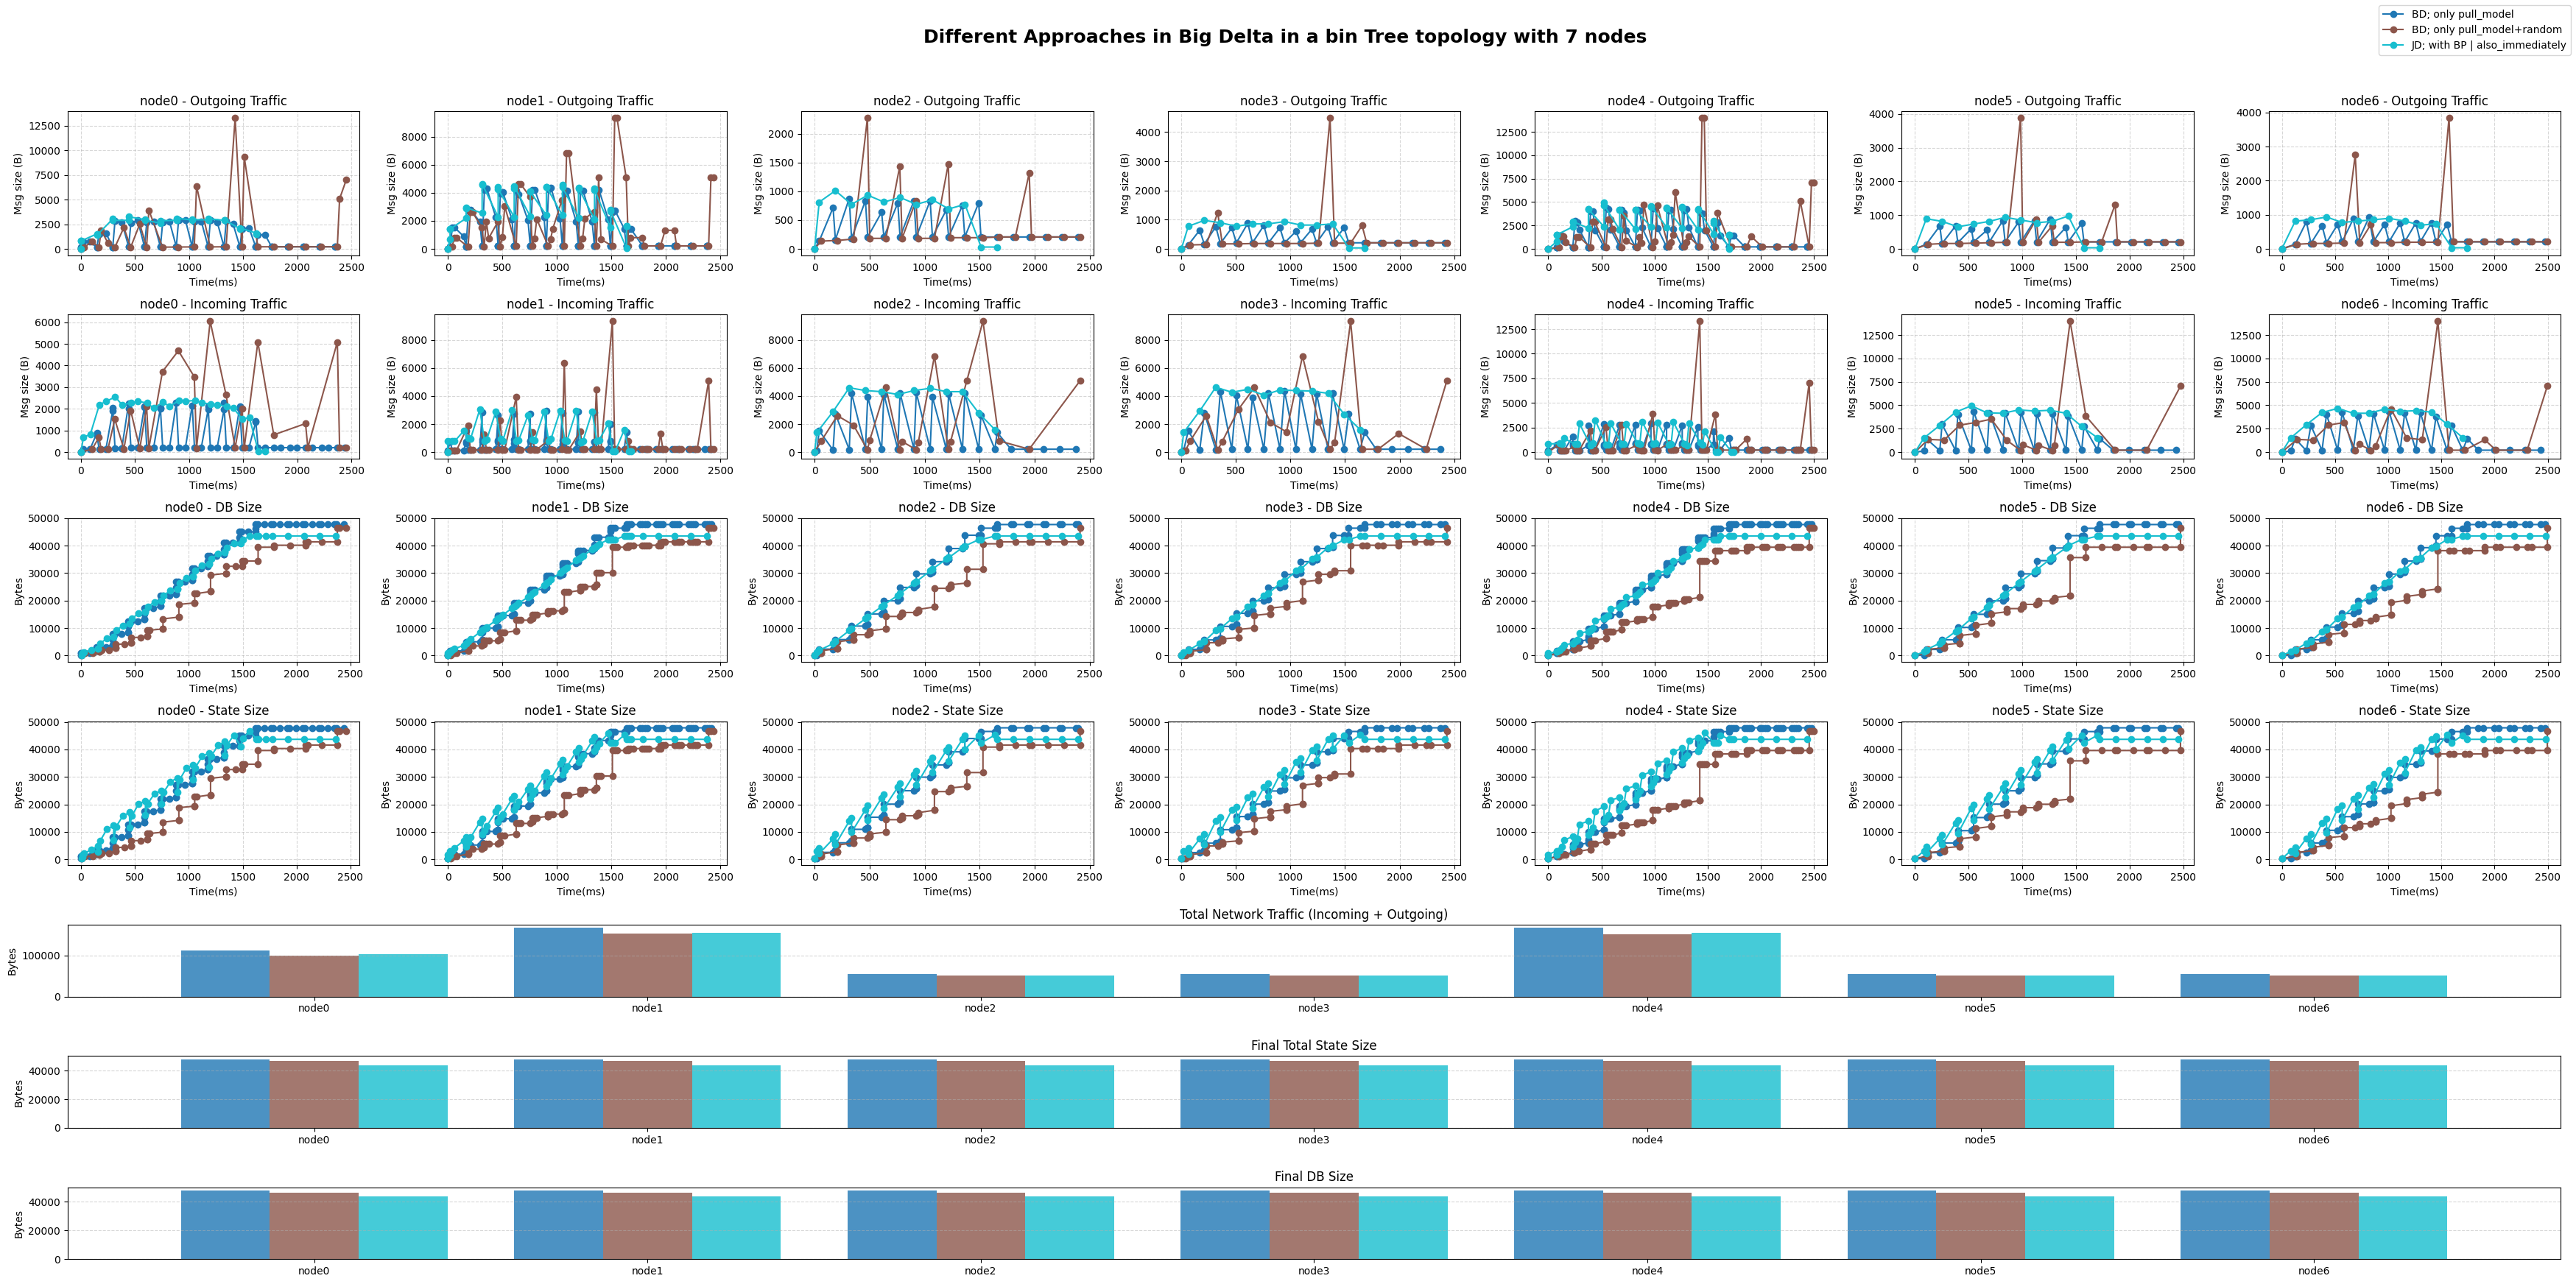

In [217]:
plot_metrics_from_files(
    [
        "../metrics/Tree, 7 nodes | BD_Node | only pull_model | also_immediately | set-Set_GO_BD.json",
        "../metrics/Tree, 7 nodes | BD_Node | only pull_model+random | also_immediately | set-Set_GO_BD.json",
        "../metrics/Tree, 7 nodes | JD_Node | bp=true | also_immediately | set-Set_GO_JD.json",
        # "../metrics/Partial mesh, 10 nodes, 4 conn | JD_Node | bp=true | only_ultimately | set-Set_GO_JD.json",
        
    ],              
    [
        "BD; only pull_model",
        "BD; only pull_model+random",
        "JD; with BP | also_immediately",
        # "JD with BP | only_ultimately",
    ],
    "Different Approaches in Big Delta in a bin Tree topology with 7 nodes"
)

In [ ]:
plot_metrics_from_files(
    [
        "../metrics/Partial mesh, 10 nodes, 4 conn | BD_Node | only pull_model | also_immediately | set-Set_GO_BD.json",
        "../metrics/Partial mesh, 10 nodes, 4 conn | BD_Node | only pull_model+random | also_immediately | set-Set_GO_BD.json",
        "../metrics/Partial mesh, 10 nodes, 4 conn | JD_Node | bp=true | also_immediately | set-Set_GO_JD.json",
        # "../metrics/Partial mesh, 10 nodes, 4 conn | JD_Node | bp=true | only_ultimately | set-Set_GO_JD.json",
        
    ],              
    [
        "only pull_model",
        "only pull_model+random",
        "JD with BP | also_immediately",
        # "JD with BP | only_ultimately",
    ],
    "Different Approaches in Big Delta in a partial mesh topology with 10 nodes with connectivity degree 4"
)

In [ ]:
plot_metrics_from_files(
    [
        "../metrics_debug/Simple pair | BD_Node | only pull_model+random | also_immediately | set-Set_GO_BD.json"
    ],
    [
        "only pull_model+random"
    ],
    "test"
)